# Regression sur l'influence des meta-données des données de DGML sur la performance des algorithmes entraînés

Dans ce notebook,nous essayons de déterminer les meta-données des jeux de données présents sur DGML influeçant le plus la performance des algorithmes entraînés et testés par AutoML à l'aide d'une regression.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
#pour créer le csv des expe de DGML:
#main_csv = pd.read_csv('open_data_ml_datasets_all_targets.csv')
#open_ml_datasets = pd.read_csv('best_datasets_ml_for_csvconf_eval.csv') 
#dgml_exp = pd.merge(main_csv,open_ml_datasets,how='inner',on=['title'])
#dgml_exp.to_csv('dgml_datasets.csv',index=None)

## Import des données

Lecture du JDD des données de DGML (uniquement classification):

In [3]:
dgml_classif = pd.read_csv('dgml_classif.csv')

On dispose de :

In [4]:
len(dgml_classif)

272

jeux de données avec les meta-données suivantes:

In [5]:
dgml_classif.columns

Index(['title', 'dgf_dataset_url', 'dgf_dataset_id', 'dgf_resource_url',
       'nb_lines', 'nb_features', 'profile_url', 'automl_url',
       'target_variable', 'task', 'dgf_resource_id', 'best_model',
       'metric_type', 'metric_value', 'score', 'missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance'],
      dtype='object')

On s'intéresse uniquement à `['title','dgf_dataset_id','nb_lines', 'nb_features','target_variable', 'task','best_model',
       'metric_type', 'metric_value','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance']`

On dispose d'assez de données pour étudier l'influence des meta-données sur la performance des algoithmes.

## 1. Regression avec meta-données de base

In [6]:
features = ['nb_lines', 'nb_features','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance']

In [7]:
dgml_classif.head()

,title,dgf_dataset_url,dgf_dataset_id,dgf_resource_url,nb_lines,nb_features,profile_url,automl_url,target_variable,task,dgf_resource_id,best_model,metric_type,metric_value,score,missing_cells_pct,nb_numerical,nb_categorical,nb_classes_target,imbalance
0,Budget Primitif - 2017 - Angers Loire M�tropole,http://www.data.gouv.fr/fr/datasets/budget-pri...,5e3221e106e3e70513320bab,https://paysdelaloire.opendatasoft.com/explore...,1936,13,https://etalab-ia.github.io/open_ML/profilings...,https://etalab-ia.github.io/open_ML/automodels...,Mode de gestion,binary_classification,5bb5a8b8-6b71-4a9a-8db5-98540e8a51a7,4_Default_Xgboost,logloss,0.197438,3.641447,0.5,4,9,2,0.190962
1,Horaires des �coles �l�mentaires et primaires ...,http://www.data.gouv.fr/fr/datasets/horaires-d...,5e32233c06e3e708b6320bb5,https://paysdelaloire.opendatasoft.com/explore...,2834,35,https://etalab-ia.github.io/open_ML/profilings...,https://etalab-ia.github.io/open_ML/automodels...,CODE_NATURE,binary_classification,c27fb866-7347-418a-a216-09d3c5770bd5,Ensemble,logloss,0.680797,2.059021,9.7,3,30,2,0.000200
2,Horaires des �coles �l�mentaires et primaires ...,http://www.data.gouv.fr/fr/datasets/horaires-d...,5e32233c06e3e708b6320bb5,https://paysdelaloire.opendatasoft.com/explore...,2834,35,https://etalab-ia.github.io/open_ML/profilings...,https://etalab-ia.github.io/open_ML/automodels...,MULTI_RYTHME,binary_classification,c27fb866-7347-418a-a216-09d3c5770bd5,Ensemble,logloss,0.152802,3.055588,9.7,3,30,2,0.426888
3,Horaires des �coles �l�mentaires et primaires ...,http://www.data.gouv.fr/fr/datasets/horaires-d...,5e32233c06e3e708b6320bb5,https://paysdelaloire.opendatasoft.com/explore...,2834,35,https://etalab-ia.github.io/open_ML/profilings...,https://etalab-ia.github.io/open_ML/automodels...,LUNDI_MATIN_DEBUT,multiclass_classification,c27fb866-7347-418a-a216-09d3c5770bd5,4_Default_Xgboost,logloss,0.004056,3.538001,9.7,3,30,12,0.196180
4,Horaires des �coles �l�mentaires et primaires ...,http://www.data.gouv.fr/fr/datasets/horaires-d...,5e32233c06e3e708b6320bb5,https://paysdelaloire.opendatasoft.com/explore...,2834,35,https://etalab-ia.github.io/open_ML/profilings...,https://etalab-ia.github.io/open_ML/automodels...,LUNDI_MATIN_FIN,multiclass_classification,c27fb866-7347-418a-a216-09d3c5770bd5,4_Default_Xgboost,logloss,0.004025,3.538117,9.7,3,30,12,0.315952


Je transforme le pourcentage des valeurs manquantes en un entier compris entre 0 et 1:

In [8]:
dgml_classif['missing_cells_pct']=dgml_classif['missing_cells_pct'].apply(lambda x: x/100)

In [9]:
X = dgml_classif[features]
y = dgml_classif['metric_value']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

Certains algorithmes (tels que SVM) sont très sensibles à la standardisation des données: nous allons faire un test sans et avec standardisation:

### Sans standardisation

#### 1. Linear Regression

In [10]:
lr = LinearRegression()

In [11]:
lr.fit(X_train,y_train)

LinearRegression()

In [12]:
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Test set score: 0.15


#### 2. SVR

In [13]:
svr = SVR() 

In [14]:
pipe = make_pipeline(svr)

In [15]:
param_grid_svr = {'svr__kernel':['rbf'],
             "svr__C": [0.1,1.0],
              "svr__gamma": ['scale','auto'],
              "svr__epsilon":[0.1,0.01]}

In [16]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [17]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1.0], 'svr__epsilon': [0.1, 0.01],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['rbf']})

In [18]:
grid.score(X_test,y_test)

0.26460371262944193

#### 3. Decision Tree

In [19]:
import numpy as np

In [20]:
param_grid_decisiontree = {"decisiontreeregressor__criterion": ["mse", "friedman_mse"],
"decisiontreeregressor__max_depth": np.arange(2, 30, 1),
}

In [21]:
decisiontree = DecisionTreeRegressor()

In [22]:
pipe = make_pipeline(decisiontree)
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree, cv=5)

In [23]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [24]:
grid.best_params_

{'decisiontreeregressor__criterion': 'mse',
 'decisiontreeregressor__max_depth': 3}

In [25]:
grid.score(X_test,y_test)

0.19134798202603387

#### 4. RandomForestRegressor

In [26]:
param_grid_rf = {'randomforestregressor__n_estimators': [10,100, 200, 400],
            'randomforestregressor__max_depth': [4, 6, 8, 10, 12, 15],
       'randomforestregressor__max_features': ["auto"],
          'randomforestregressor__min_samples_split': [2,10, 20, 30],
             }

In [27]:
rf =  RandomForestRegressor()

In [28]:
pipe = make_pipeline(rf)
grid = GridSearchCV(pipe, param_grid=param_grid_rf, cv=5)

In [29]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 8, 10, 12,
                                                              15],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__min_samples_split': [2, 10, 20,
                                                                      30],
                         'randomforestregressor__n_estimators': [10, 100, 200,
                                                                 400]})

In [30]:
grid.score(X_test,y_test)

0.4019741906259082

#### 5. GradientBoostRegressor

In [31]:
gbr = GradientBoostingRegressor()

In [32]:
param_grid_gbr = {'gradientboostingregressor__n_estimators': [10,100, 200, 400],
             'gradientboostingregressor__max_depth': [3,4, 6, 8, 10, 12, 15],
             'gradientboostingregressor__max_features': [None],
             'gradientboostingregressor__min_samples_split': [2,10, 20, 30]}

In [33]:
pipe = make_pipeline(gbr)
grid = GridSearchCV(pipe, param_grid=param_grid_gbr, cv=5)

In [34]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             param_grid={'gradientboostingregressor__max_depth': [3, 4, 6, 8,
                                                                  10, 12, 15],
                         'gradientboostingregressor__max_features': [None],
                         'gradientboostingregressor__min_samples_split': [2, 10,
                                                                          20,
                                                                          30],
                         'gradientboostingregressor__n_estimators': [10, 100,
                                                                     200,
                                                                     400]})

In [35]:
grid.score(X_test,y_test)

0.4292843186246481

#### 6. XGBoost Regressor

In [36]:
xgboost = XGBRegressor()

In [37]:
param_grid_xgboost = {
    "xgbregressor__objective": ["reg:squarederror"],
    "xgbregressor__eval_metric": ["rmse"],
    "xgbregressor__eta": [0.05, 0.075, 0.1, 0.15],
    "xgbregressor__max_depth": [1, 2, 3, 4],
    "xgbregressor__min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "xgbregressor__subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "xgbregressor__colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

In [38]:
pipe = make_pipeline(xgboost)
grid = GridSearchCV(pipe, param_grid=param_grid_xgboost, cv=5)

In [39]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     min_child_weight=None,
                             

In [40]:
grid.score(X_test,y_test)

0.45919534168013454

### Avec StandardScaler

#### 1. Linear Regression

In [41]:
stscaler = StandardScaler()

In [42]:
lr = LinearRegression()

In [43]:
pipe = make_pipeline(stscaler,lr)

In [44]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [45]:
pipe.score(X_test,y_test)

0.1509550164060791

#### 2. SVR

In [46]:
pipe = make_pipeline(stscaler,svr)

In [47]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [48]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1.0], 'svr__epsilon': [0.1, 0.01],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['rbf']})

In [49]:
grid.score(X_test,y_test)

0.2884520379738862

### 3. DecisionTreeRegressor

In [50]:
pipe = make_pipeline(stscaler,decisiontree)

In [51]:
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree,cv=5)

In [52]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [53]:
grid.score(X_test,y_test)

0.19134798202603365

### 4.RandomForestRegressor

In [54]:
pipe = make_pipeline(stscaler,rf)

In [55]:
grid = GridSearchCV(pipe, param_grid=param_grid_rf,cv=5)

In [56]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 8, 10, 12,
                                                              15],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__min_samples_split': [2, 10, 20,
                                                                      30],
                         'randomforestregressor__n_estimators': [10, 100, 200,
                                                                 400]})

In [57]:
grid.score(X_test,y_test)

0.39683536560005406

#### 5.GradientBoostingRegressor

In [58]:
pipe = make_pipeline(stscaler,gbr)

In [59]:
grid = GridSearchCV(pipe, param_grid=param_grid_gbr,cv=5)

In [60]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             param_grid={'gradientboostingregressor__max_depth': [3, 4, 6, 8,
                                                                  10, 12, 15],
                         'gradientboostingregressor__max_features': [None],
                         'gradientboostingregressor__min_samples_split': [2, 10,
                                                                          20,
                                                                          30],
                         'gradientboostingregressor__n_estimators': [10, 100,
                                                                     200,
                                                                     400]})

In [61]:
grid.score(X_test,y_test)

0.40765058158223233

#### 6. MLPRegressor

In [63]:
mlp = MLPRegressor()

In [64]:
pipe = make_pipeline(stscaler,mlp)

In [65]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor())])

In [66]:
pipe.score(X_test,y_test)

0.02122649841027313

#### 7. XGBoostRegressor

In [67]:
pipe = make_pipeline(stscaler,xgboost)

In [68]:
grid = GridSearchCV(pipe,param_grid=param_grid_xgboost,cv=5)

In [69]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                            

In [70]:
grid.score(X_test,y_test)

0.516712834207059

### Avec MinMaxScaler

In [71]:
mmscaler = MinMaxScaler()

#### 1. Linear Regression

In [72]:
pipe = make_pipeline(mmscaler,lr)

In [73]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [74]:
pipe.score(X_test,y_test)

0.15095501640607956

#### 2.SVR

In [75]:
pipe = make_pipeline(mmscaler,svr)

In [76]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [77]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1.0], 'svr__epsilon': [0.1, 0.01],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['rbf']})

In [78]:
grid.score(X_test,y_test)

0.26758422558812966

#### 3. DecisionTree

In [79]:
pipe = make_pipeline(mmscaler,decisiontree)

In [80]:
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree,cv=5)

In [81]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [82]:
grid.score(X_test,y_test)

0.19134798202603387

#### 4. RandomForestRegressor

In [83]:
pipe = make_pipeline(mmscaler,rf)

In [84]:
grid = GridSearchCV(pipe, param_grid=param_grid_rf,cv=5)

In [85]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 8, 10, 12,
                                                              15],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__min_samples_split': [2, 10, 20,
                                                                      30],
                         'randomforestregressor__n_estimators': [10, 100, 200,
                                                                 400]})

In [86]:
grid.score(X_test,y_test)

0.341145656288278

#### 5. GradientBoostingRegressor

In [87]:
pipe = make_pipeline(mmscaler,gbr)

In [88]:
grid = GridSearchCV(pipe, param_grid=param_grid_gbr,cv=5)

In [89]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             param_grid={'gradientboostingregressor__max_depth': [3, 4, 6, 8,
                                                                  10, 12, 15],
                         'gradientboostingregressor__max_features': [None],
                         'gradientboostingregressor__min_samples_split': [2, 10,
                                                                          20,
                                                                          30],
                         'gradientboostingregressor__n_estimators': [10, 100,
                                                                     200,
                                                                     400]})

In [90]:
grid.score(X_test,y_test)

0.42631390107350287

#### 6. MLPRegressor

In [91]:
pipe = make_pipeline(mmscaler,mlp)

In [92]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('mlpregressor', MLPRegressor())])

In [93]:
pipe.score(X_test,y_test)

0.1396977029315828

#### 7. XGBoostRegressor

In [94]:
pipe = make_pipeline(mmscaler,xgboost)

In [95]:
grid = GridSearchCV(pipe, param_grid=param_grid_xgboost,cv=5)

In [96]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                

In [97]:
grid.score(X_test,y_test)

0.4639779626688225

## Résultats

In [98]:
algos = ['Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor','Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor','Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor']

In [99]:
data_standardisation = [None,None,None,None,None,None,None,'StandardScaler','StandardScaler','StandardScaler','StandardScaler','StandardScaler','StandardScaler','StandardScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler']

In [100]:
r2 = [0.15,0.28,0.19,0.41,0.37,0.31,0.48,0.15,0.28,0.19,0.44,0.41,0.15,0.51,0.15,0.26,0.09,0.4,0.43,0.16,0.46]

In [101]:
df = pd.DataFrame(list(zip(algos, data_standardisation,r2)),
               columns =['Algorithm', 'Data_Standardization','R2'])

In [102]:
df

,Algorithm,Data_Standardization,R2
0,Linear Regression,None,0.15
1,SVR,None,0.28
2,DecisionTree,None,0.19
3,RandomForestRegressor,None,0.41
4,GradientBoostingRegressor,None,0.37
5,MLPRegressor,None,0.31
6,XGBoostRegressor,None,0.48
7,Linear Regression,StandardScaler,0.15
8,SVR,StandardScaler,0.28
9,DecisionTree,StandardScaler,0.19


**Le meilleur résultat obtenu,  R² = 0.51 pour XGBoostRegressor, n'est pas satisfaisant.**

On ajoute de nouvelles features pour essayer d'améliorer notre algorithme.

## 2. Ajout de features: task and best model

On considère deux features catégorielles supplémentaires dans notre analyse:
1. `task`: variable catégorielle binaire (binary_classification ou multiclass_classification) <br>
2. `best_model`: variable catégorielle du nom du meilleur algorithme pour ce jeu de données

Encoding de ces deux variables:

In [103]:
dgml_classif = pd.read_csv('dgml_classif.csv')
features = ['nb_lines', 'nb_features','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance','task','best_model']

In [104]:
dgml_classif['missing_cells_pct']=dgml_classif['missing_cells_pct'].apply(lambda x: x/100)

In [105]:
one_hot_enc = OneHotEncoder(handle_unknown = 'ignore')

In [106]:
X = dgml_classif[features]
y = dgml_classif['metric_value']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [107]:
num_cols = ['nb_lines', 'nb_features','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance']
cat_cols = ['task','best_model']

In [108]:
columns_trans =  make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

### 1. Linear Regression

In [109]:
pipe = make_pipeline(columns_trans,lr)

In [110]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['nb_lines', 'nb_features',
                                                   'missing_cells_pct',
                                                   'nb_numerical',
                                                   'nb_categorical',
                                                   'nb_classes_target',
                                                   'imbalance']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['task', 'best_model'])])),
                ('linearregression', LinearRegression())])

In [111]:
pipe.score(X_test,y_test)

0.4391641092016423

### 2. SVR

In [112]:
pipe = make_pipeline(columns_trans,svr)

In [113]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [114]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance']),
                                                                        ('onehotencoder',
            

In [115]:
grid.score(X_test,y_test)

0.548838071916969

### 3. DecisionTreeRegressor

In [116]:
columns_trans =  make_column_transformer((one_hot_enc,cat_cols),remainder="passthrough")

In [117]:
pipe = make_pipeline(columns_trans,decisiontree)

In [118]:
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree,cv=5)

In [119]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['task',
                                                                          'best_model'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27,

In [120]:
grid.score(X_test,y_test)

0.6614129765187098

### 4. RandomForestRegressor

In [121]:
pipe = make_pipeline(columns_trans,rf)

In [122]:
grid = GridSearchCV(pipe, param_grid=param_grid_rf,cv=5)

In [123]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['task',
                                                                          'best_model'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 8, 10, 12,
                                                              15],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__min_samples_split': [2, 10, 20,
                         

In [124]:
grid.score(X_test,y_test)

0.5293736381162468

### 5. GradientBoostingRegressor

In [125]:
columns_trans = make_column_transformer((mmscaler,num_cols),(one_hot_enc,cat_cols))

In [126]:
pipe = make_pipeline(columns_trans,gbr)

In [127]:
grid = GridSearchCV(pipe, param_grid=param_grid_gbr,cv=5)

In [128]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance']),
                                                                        ('onehotencoder',
                

In [129]:
grid.score(X_test,y_test)

0.4571643195759729

### 6. MLPRegressor

In [130]:
columns_trans = make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

In [131]:
pipe = make_pipeline(columns_trans,mlp)

In [132]:
param_grid_mlp = {"mlpregressor__hidden_layer_sizes" : [(50,50,50), (50,100,50),(100,)],
                       "mlpregressor__activation" : ["relu","tanh"], 
                       "mlpregressor__solver" : ["adam"], 
                       "mlpregressor__alpha" : [0.0001,0.001,0.00001], 
                       "mlpregressor__batch_size" : [100,200,300,"auto"],
                       "mlpregressor__learning_rate_init" : [0.0001,0.001,0.01], 
                       "mlpregressor__random_state" : [64]
                  }

In [133]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance']),
                                                                        ('onehotencoder',
                

In [134]:
grid.score(X_test,y_test)

0.4571643195759729

### 7. XGBoostRegressor

In [135]:
columns_trans = make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

In [136]:
pipe = make_pipeline(columns_trans,xgboost)

In [137]:
grid = GridSearchCV(pipe, param_grid=param_grid_xgboost,cv=5)

In [138]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance']),
                                                                        ('onehotencoder',
            

In [139]:
grid.score(X_test,y_test)

0.6022040668237685

## Résultats 

In [140]:
algos = ['Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor']

In [141]:
data_standardisation = ['StandardScaler','StandardScaler',None,'StandardScaler','MinMaxScaler',None,'StandardScaler']

In [142]:
r2 = [0.43,0.54,0.66,0.62,0.45,0.45,0.6]

In [143]:
df = pd.DataFrame(list(zip(algos, data_standardisation,r2)),
               columns =['Algorithm', 'Data_Standardization','R2'])

In [144]:
df

,Algorithm,Data_Standardization,R2
0,Linear Regression,StandardScaler,0.43
1,SVR,StandardScaler,0.54
2,DecisionTree,None,0.66
3,RandomForestRegressor,StandardScaler,0.62
4,GradientBoostingRegressor,MinMaxScaler,0.45
5,MLPRegressor,None,0.45
6,XGBoostRegressor,StandardScaler,0.60


**Le score des la régression a légerment augmenté mais les résultats restent pas assez satisfaisants**

## 3. Feature engineering

On crée de nouvelles features:
1. `row_col_prop`: proportion du nombre de lignes par rapport au nombre de colonnes <br>
2. `num_prop`: proportion du nombre de variables numériques par rapport au nombre total de variables <br>
3. `cat_prop`: proportion du nombre de variables catégorielles par rapport au nombre total de variables <br>

On modifie également la colonne `best_model` pour que les catégories soient cohérentes

In [145]:
dgml_classif['row_col_prop']=dgml_classif['nb_features']/dgml_classif['nb_lines']

In [146]:
dgml_classif['num_prop']=dgml_classif['nb_numerical']/dgml_classif['nb_lines']

In [147]:
dgml_classif['cat_prop']=dgml_classif['nb_categorical']/dgml_classif['nb_lines']

In [148]:
dgml_classif.best_model.replace({'4_Default_Xgboost': 'Default_Xgboost', "3_Default_Xgboost": 'Default_Xgboost',
                                '2_DecisionTree':'DecisionTree','5_Default_RandomForest':'Default_RandomForest',
                                '5_Default_NeuralNetwork':'Default_NeuralNetwork',
                                '6_Default_RandomForest':'Default_RandomForest',
                                '4_Default_NeuralNetwork':'Default_NeuralNetwork'},
                                inplace=True)

In [149]:
features = ['nb_lines',
 'nb_features',
 'missing_cells_pct',
 'nb_numerical',
 'nb_categorical',
 'nb_classes_target',
 'imbalance',
 'task',
 'best_model',
  'row_col_prop',
           'num_prop',
           'cat_prop']

In [150]:
X = dgml_classif[features]
y = dgml_classif['metric_value']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

### 1. Linear Regression

In [151]:
num_cols = ['nb_lines', 'nb_features','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance','row_col_prop',
           'num_prop',
           'cat_prop']

In [152]:
columns_trans =  make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

In [153]:
pipe = make_pipeline(columns_trans,lr)

In [154]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['nb_lines', 'nb_features',
                                                   'missing_cells_pct',
                                                   'nb_numerical',
                                                   'nb_categorical',
                                                   'nb_classes_target',
                                                   'imbalance', 'row_col_prop',
                                                   'num_prop', 'cat_prop']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['task', 'best_model'])])),
                ('linearregression', LinearRegression())])

In [155]:
pipe.score(X_test,y_test)

0.4047681062305125

### 2. SVR

In [156]:
pipe = make_pipeline(columns_trans,svr)

In [157]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [158]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance',
                                                                          'row_col_prop',
              

In [159]:
grid.score(X_test,y_test)

0.5553703339415739

### 3. DecisionTree

In [160]:
columns_trans =  make_column_transformer((one_hot_enc,cat_cols),remainder="passthrough")

In [161]:
pipe = make_pipeline(columns_trans,decisiontree)

In [162]:
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree,cv=5)

In [164]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['task',
                                                                          'best_model'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27,

In [165]:
grid.score(X_test,y_test)

0.6006533379285743

## Arbre de décision

Nous choisissons d'analyser le DecisionTreeRegressor car cet algorithme donne d'assez bons résultats et ces résultats sont facilement explicables.

In [166]:
from sklearn import tree

In [167]:
model = grid.best_estimator_.named_steps['decisiontreeregressor']

In [168]:
transformer= grid.best_estimator_.named_steps['columntransformer']

In [169]:
one_hot = transformer.named_transformers_['onehotencoder']

In [170]:
one_hot.get_feature_names()

array(['x0_binary_classification', 'x0_multiclass_classification',
       'x1_DecisionTree', 'x1_Default_NeuralNetwork',
       'x1_Default_RandomForest', 'x1_Default_Xgboost', 'x1_Ensemble'],
      dtype=object)

In [171]:
feature_names = np.array([ 'x0_binary_classification', 'x0_multiclass_classification',
       'x1_DecisionTree', 'x1_Default_NeuralNetwork',
       'x1_Default_RandomForest', 'x1_Default_Xgboost', 'x1_Ensemble',
                       'nb_lines','nb_features', 'missing_cells_pct', 'nb_numerical',
       'nb_categorical', 'nb_classes_target', 'imbalance', 'row_col_prop',
 'num_prop','cat_prop',  ])

In [172]:
import matplotlib.pyplot as plt

In [173]:
fig = plt.figure(figsize=(200,120))
tree.plot_tree(model,feature_names=feature_names,filled=True,fontsize=80) 
fig.savefig('decision_tree.png')

In [174]:
import shap

In [176]:
explainer = shap.TreeExplainer(model)

In [177]:
shap_values = explainer.shap_values(transformer.fit_transform(X_train))

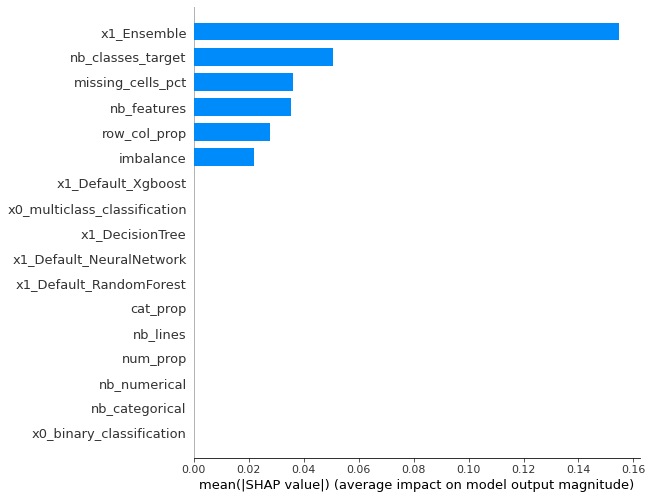

In [178]:
shap.summary_plot(shap_values, transformer.fit_transform(X_train), plot_type="bar",feature_names=feature_names)

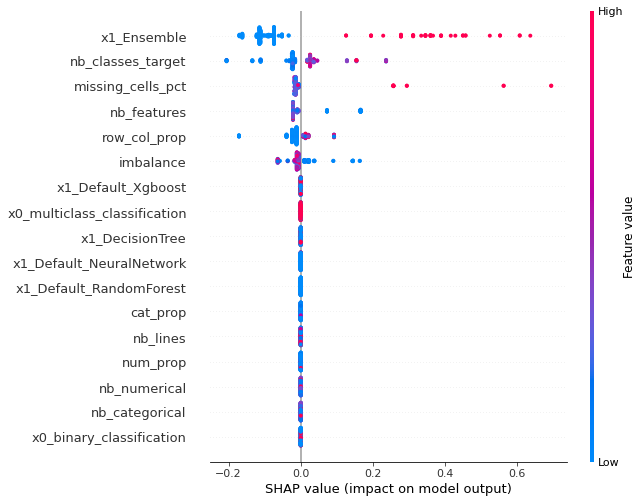

In [179]:
shap.summary_plot(shap_values, transformer.fit_transform(X_train),feature_names=feature_names)

### 4. RandomForest

In [180]:
pipe = make_pipeline(columns_trans,rf)

In [181]:
grid = GridSearchCV(pipe, param_grid=param_grid_rf,cv=5)

In [182]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['task',
                                                                          'best_model'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 8, 10, 12,
                                                              15],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__min_samples_split': [2, 10, 20,
                         

In [183]:
grid.score(X_test,y_test)

0.634687960006889

### 5. GradientBoostingRegressor

In [184]:
columns_trans = make_column_transformer((mmscaler,num_cols),(one_hot_enc,cat_cols))

In [185]:
pipe = make_pipeline(columns_trans,gbr)

In [186]:
grid = GridSearchCV(pipe, param_grid=param_grid_gbr,cv=5)

In [187]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance',
                                                                          'row_col_prop',
                  

In [188]:
grid.score(X_test,y_test)

0.40829259429449105

### 6. MLP

In [189]:
columns_trans = make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

In [190]:
pipe = make_pipeline(columns_trans,mlp)

In [191]:
grid = GridSearchCV(pipe, param_grid=param_grid_mlp,cv=5)

In [ ]:
#grid.fit(X_train,y_train)

In [ ]:
grid.score(X_test,y_test)

### 7. XGBoost

In [2]:
columns_trans = make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

In [ ]:
pipe = make_pipeline(columns_trans,xgboost)

In [ ]:
grid = GridSearchCV(pipe, param_grid=param_grid_xgboost,cv=5)

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
grid.score(X_test,y_test)

## Résultats finaux

In [4]:
algos = ['Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor']

In [3]:
r2 = [0.4,0.55,0.6,0.63,0.41,0.45,0.6]

In [8]:
df = pd.DataFrame(list(zip(algos, r2)),
               columns =['Algorithm', 'R2'])

In [9]:
df

,Algorithm,R2
0,Linear Regression,0.40
1,SVR,0.55
2,DecisionTree,0.60
3,RandomForestRegressor,0.63
4,GradientBoostingRegressor,0.41
5,MLPRegressor,0.45
6,XGBoostRegressor,0.60


### Remarks

Usa penultimo modello di DT nel grafico (migliori perf)